<a href="https://colab.research.google.com/github/Shahid1993/colab-notebooks/blob/master/word_prediction_tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive


In [71]:
# Mounting Google Drive to Load Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  !pip install -q -U "tensorflow-gpu==2.0.0rc0"

In [0]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
#tf.set_random_seed(42)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout#, CuDNNLSTM
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.core import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
import re

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

# Loading Data

In [74]:
path = "./drive/My Drive/ML/data/1-billion-word-language-modeling-benchmark-r13output/training-monolingual.tokenized.shuffled/news.en-00001-of-00100"

training_corpus = open(path).read().lower()
print('corpus length:', len(training_corpus))

corpus length: 41915785


# Preprocessing

In [75]:
chars = sorted(list(set(training_corpus)))

print('Unique Character count before preprocessing:', len(chars))

#training_corpus = re.sub(r'[^abcdefghijklmnopqrstuvwxyz0123456789 !"&\',-.:;?_]', '', training_corpus)
training_corpus = re.sub(r'[^abcdefghijklmnopqrstuvwxyz0123456789 !&\',-.]', '', training_corpus)

print('corpus length after preprocessing:', len(training_corpus))

#chars = sorted(list(set(training_corpus)))
chars = 'abcdefghijklmnopqrstuvwxyz0123456789 !&\',-.'
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Unique Character count after preprocessing:', len(chars))

Unique Character count before preprocessing: 149
corpus length after preprocessing: 41412210
Unique Character count after preprocessing: 43


In [76]:
SENTENCE_LENGTH = 40
STRIDE = 40
sentences = []
next_chars = []
for i in range(0, len(training_corpus) - SENTENCE_LENGTH, STRIDE):
    sentences.append(training_corpus[i: i + SENTENCE_LENGTH])
    next_chars.append(training_corpus[i + SENTENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 1035305


# Word Vectorization

In [0]:
X = np.zeros((len(sentences), SENTENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [78]:
sentences[20200]

'ld finishing second , well ahead of thir'

In [79]:
next_chars[20200]

'd'

In [80]:
X[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [81]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False])

In [82]:
X.shape

(1035305, 40, 43)

In [83]:
y.shape

(1035305, 43)

# Building the Model

In [0]:
model = Sequential([
                    # CuDNNLSTM(256, input_shape=(None, len(chars)), return_sequences=True),
                    # CuDNNLSTM(128),
                    LSTM(512, input_shape=(None, len(chars)), recurrent_dropout=0, use_bias=True, return_sequences=True),
                    Dropout(0.2),
                    LSTM(512, recurrent_dropout=0, use_bias=True ),
                    Dropout(0.2),
                    #Dense(512, activation='relu'),
                    Dense(len(chars), activation='softmax')
])

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 512)         1138688   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                22059     
Total params: 3,259,947
Trainable params: 3,259,947
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=512, epochs=1, shuffle=True).history

Train on 983539 samples, validate on 51766 samples
983539/983539 [==============================] - 495s 503us/sample - loss: 2.2057 - accuracy: 0.3556 - val_loss: 1.8055 - val_accuracy: 0.4615


# Save as Keras .h5 model

In [0]:
model.save('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1.h5')
pickle.dump(history, open('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_history.p', "wb"))

#Loading the Keras .h5 Model

In [54]:
reloaded = tf.keras.models.load_model('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1.h5')
history = pickle.load(open('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_history.p', "rb"))


reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 512)         1138688   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                22059     
Total params: 3,259,947
Trainable params: 3,259,947
Non-trainable params: 0
_________________________________________________________________


In [55]:
history

{'accuracy': [0.38651034],
 'loss': [2.0856837101533925],
 'val_accuracy': [0.4871151],
 'val_loss': [1.7130006977539363]}

#Retraining the Existing Model

In [0]:
history = reloaded.fit(X, y, validation_split=0.05, batch_size=512, epochs=1, shuffle=True).history

#Saving Retrained model as a new Keras .h5 Model

In [0]:
reloaded.save('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_2.h5')
pickle.dump(history, open('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_2_history.p', "wb"))

# Export as SavedModel

In [87]:
#cloned_model = tf.keras.models.clone_model(model)
tf.saved_model.save(model, './drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_K')

INFO:tensorflow:Assets written to: ./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_K/assets


# Loading the SavedModel as a Keras Model

In [88]:
reloaded_sm_keras = tf.keras.models.load_model('./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_K')
reloaded_sm_keras.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 512)         1138688   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                22059     
Total params: 3,259,947
Trainable params: 3,259,947
Non-trainable params: 0
_________________________________________________________________


#Evaluation - Model Metrics

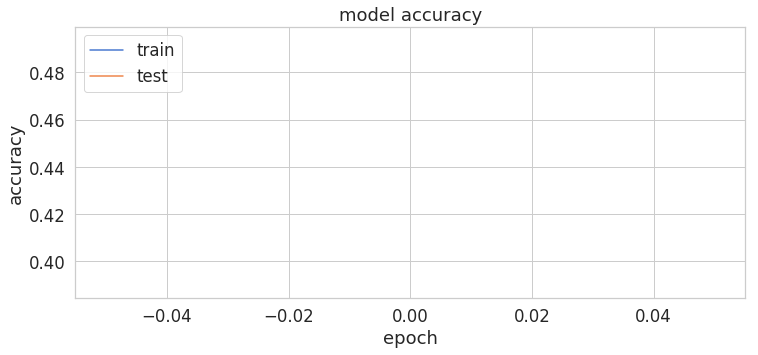

In [34]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

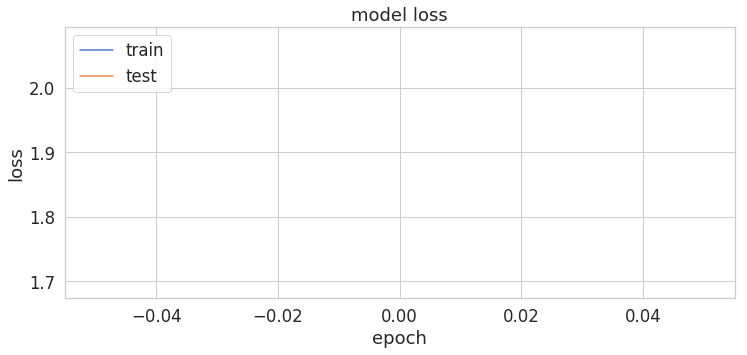

In [35]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [0]:
def prepare_input(text):
    x = np.zeros((1, len(text), len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [0]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = reloaded_sm_keras.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [0]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = reloaded_sm_keras.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [0]:


# "A flowchart represents the phases of managing travel for planned special events. The phases are as follows (in the respective order): Initial planning activities, feasibility study, traffic management plan, implementation activities, day-of-event activities, and post-event activities."

input = [
    "A flowchart repr", # 'esents '
    "A flowchart represents ", # 'the '
    "A flowchart represents the ", # 'company '
    "A flowchart represents the p", # 'roduct '
    "A flowchart represents the ph", # 'one '
    "A flowchart represents the pha", # 'rmaceutical '
    "A flowchart represents the phas", # 'e '
    "A flowchart represents the phases", # ' of ' 
    "A flowchart represents the phases of ", # 'the ' 
    "A flowchart represents the phases of m", # 'ore '
    "A flowchart represents the phases of ma", # 'rkets '
    "A flowchart represents the phases of man", # 'y '    
    "A flowchart represents the phases of mana", # 'gement '
    "A flowchart represents the phases of managi", # 'ng '
    "A flowchart represents the phases of managing tr", # 'aditional'
    "A flowchart represents the phases of managing trav", # 'el '
    "A flowchart represents the phases of managing travel f", # 'or '
    "A flowchart represents the phases of managing travel for pl", # 'ans '
    "A flowchart represents the phases of managing travel for plann", # ['ed ', 'ing ', 's ', ' to ', 't ']    
    "A flowchart represents the phases of managing travel for planned sp", #['ecial ', 'ace ', 'otling ', 'iriting ', 'rings ']
    "A flowchart represents the phases of managing travel for planned special ", #['community ', 'products ', 'state ', 'and ', 'report ']
    "A flowchart represents the phases of managing travel for planned special ev", #['ent ', 'idence ', 'olution ', 'acuation ', 'y ']
    "A flowchart represents the phases of managing travel for planned special events. T", #['he ', 'o ', 'rading ', 'ake ', 'ime ']
    "A flowchart represents the phases of managing travel for planned special events. The phas", #['e ', 'i ', 'a ', ' service ', 'os ']
    "A flowchart represents the phases of managing travel for planned special events. The phases are as fol",     
]

# A sketch shows different aged people standing on a line holding their hands.

input2 = [
    "A sketc", #['h ', ' , ', 'o ', 'tic ', 'call, ']
    "A sketch shows dif", #['ferent ', ' .the ', 't ', 'pers ', 'atar ']
    "A sketch shows different aged peo", #['ple ', 'ris ', 'lise ', 'sition ', 'bles ']
    "A sketch shows different aged people standi", #['ng ', 'de ', 'stan ', 'er ', 'an ']
    "A sketch shows different aged people standing on a lin", #['e ', 'k ', 'd ', 'ting ', 'col ']
    "A sketch shows different aged people standing on a line hol", #['ding ', 'iday ', 'e ', 'ly ', 'ored ']
    "A sketch shows different aged people standing on a line holding ", #['the ', 'and ', 'of ', 'in ', '.the ']
    "A sketch shows different aged people standing on a line holding thei", #['r ', 'n ', 'e ', 'm ', 'g ']
    "A sketch shows different aged people standing on a line holding their ", #['company ', 'second ', 'product ', 'first ', 'last ']
    "A sketch shows different aged people standing on a line holding their h", #['ome ', 'ealth ', 'ands ', 'igh ', 'uman ']
    "A sketch shows different aged people standing on a line holding their ha", #['nds ', 'rd ', 'lf ', 'mmer ', 've ']

]

In [94]:
for i in input:
    seq = i.lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

a flowchart repr
['ess ', 'oved ', 'ised ', 'aced ', 'ys ']

a flowchart represents 
['and ', 'to ', '.the ', 'of ', ', ']

a flowchart represents the 
['security ', 'many ', 'companies ', 'resurted ', 'the ']

a flowchart represents the p
['rosection ', 'olition ', 'art ', 'ersing ', 'lay ']

a flowchart represents the ph
['ones ', 'an ', 'ing ', 'en ', 'riss ']

a flowchart represents the pha
['n ', 'rs ', 'ct ', 'ss ', 'lled ']

a flowchart represents the phas
['s ', 'e ', 'ing ', 't ', ' and ']

a flowchart represents the phases
[' and ', 's ', 't ', 'ing ', 'e ']

a flowchart represents the phases of 
['the ', 'a ', 'many ', 'service ', 'her ']

a flowchart represents the phases of m
['any ', 'ore ', 'ission ', 'erican ', 'ust ']

a flowchart represents the phases of ma
['ny ', 'rke ', 'ster ', 'de ', 'lled ']

a flowchart represents the phases of man
['y ', ' and ', 'ks ', 'ce ', 'd ']

a flowchart represents the phases of mana
['ge ', 'st ', 're ', 'ling ', ' and ']

a flowchart

In [95]:
!zip -r model.zip {'./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_K'}

	zip warning: name not matched: ./drive/My
	zip warning: name not matched: Drive/ML/Models/word_completion_prediction_2/t2/1_1_K

zip error: Nothing to do! (try: zip -r model.zip . -i ./drive/My Drive/ML/Models/word_completion_prediction_2/t2/1_1_K)
